In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas as pd
import os
od.download("https://www.kaggle.com/datasets/yehongjiang/pokemon-sprites-images")
pokemonData = pd.read_csv("pokemon_labels.csv")

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms as T
import torch.optim as optim
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: a
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/yehongjiang/pokemon-sprites-images


100%|██████████| 19.7M/19.7M [00:00<00:00, 734MB/s]

In [ ]:
class PokemonDataset(Dataset):
    def __init__(self, root_dir, dataframe, transform=None):
        self.root_dir = root_dir
        # Filter out rows where the folder is missing
        valid_indices = []
        invalid_ids = []
        for idx in range(len(dataframe)):
            row = dataframe.iloc[idx]
            poke_id = str(row["id"])
            folder_found = False
            for f in os.listdir(self.root_dir):
                if f.startswith(f"{poke_id}-"):
                    folder_found = True
                    break
            if folder_found:
                valid_indices.append(idx)
            else:
                invalid_ids.append(poke_id)

        self.df = dataframe.iloc[valid_indices].reset_index(drop=True)
        self.transform = transform

        print(f"Original dataset size: {len(dataframe)}")
        print(f"Filtered dataset size: {len(self.df)}")
        print(f"Number of entries filtered out: {len(invalid_ids)}")
        if invalid_ids:
            print(f"First 10 filtered IDs: {invalid_ids[:10]}")


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        poke_id = str(row["id"])

        folder = None
        for f in os.listdir(self.root_dir):
            if f.startswith(f"{poke_id}-"):
                folder = os.path.join(self.root_dir, f)
                break

        if folder is None:
            # This should not happen after filtering, but keep for safety
            raise FileNotFoundError(f"Brak folderu dla id={poke_id}")

        sprite_dir = os.path.join(folder, "front", "normal")
        files = [os.path.join(sprite_dir, fn) for fn in os.listdir(sprite_dir) if fn.endswith(".png")]
        if len(files) == 0:
            raise FileNotFoundError(f"Brak sprite'ów w {sprite_dir}")

        img_path = files[0]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        label = row.drop(["id", "name"]).values.astype("float32")
        label = torch.tensor(label)

        return img, label

In [ ]:
print(os.listdir("./pokemon-sprites-images/pokemon_images/sprites")[:1000])

['0987-Necrozma Dusk-800', '0491-Deoxys Attack-386', '0188-Tauros-128', '0552-Chatot-441', '0521-Wormadam Plant-413', '0616-Victini-494', '0110-Victreebel-71', '0119-Ponyta-77', '1092-Dracovish-882', '0648-Gigalith-526', '0474-Metang-375', '0319-Blissey-242', '0213-Moltres-146', '0764-Deino-633', '0410-Wailmer-320', '0620-Tepig-498', '0589-Gallade-475', '0227-Typhlosion-157', '0713-Vanillish-583', '0743-Cubchoo-613', '0664-Swadloon-541', '0173-Kangaskhan Mega-115', '0934-Wimpod-767', '0386-Sableye-302', '0167-Weezing Galar-110', '0740-Axew-610', '0356-Seedot-273', '0710-Ducklett-580', '0749-Stunfisk Galar-618', '0331-Grovyle-253', '0180-Mr Mime-122', '0972-Tapu Bulu-787', '0980-Pheromosa-795', '0081-Diglett-50', '0530-Cherubi-420', '0771-Virizion-640', '0832-Barbaracle-689', '0068-Ninetales-38', '0097-Poliwag-60', '0079-Venonat-48', '0751-Mienshao-620', '0295-Swinub-220', '0411-Wailord-321', '1080-Frosmoth-873', '0348-Wurmple-265', '0329-Celebi-251', '0985-Necrozma-800', '1112-Regidrag

In [ ]:
def sinusoidal_embedding(timesteps: torch.LongTensor, dim: int):
    """
    timesteps: (B,) long tensor
    returns: (B, dim) float tensor
    """
    assert len(timesteps.shape) == 1
    device = timesteps.device
    half = dim // 2
    freqs = torch.exp(-torch.log(torch.tensor(10000.0, device=device)) * torch.arange(half, device=device) / (half - 1))
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb

In [ ]:
transform = T.Compose([
    T.Resize((96, 96), interpolation=Image.NEAREST),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = PokemonDataset(root_dir="./pokemon-sprites-images/pokemon_images/sprites", dataframe = pokemonData, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

Original dataset size: 1072
Filtered dataset size: 116
Number of entries filtered out: 956
First 10 filtered IDs: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
class ConvBlock(nn.Module):
    """
    Standard convolutional block with GroupNorm, SiLU activation,
    a residual connection, and time embedding injection.
    """
    def __init__(self, in_ch, out_ch, time_emb_dim, is_res=True):
        super().__init__()
        self.is_res = is_res
        self.main_path = nn.Sequential(
            nn.GroupNorm(8, in_ch),
            nn.SiLU(),
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
        )
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_ch),
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, temb):
        h = self.main_path(x)
        time_emb = self.time_mlp(temb).unsqueeze(-1).unsqueeze(-1)
        h = h + time_emb
        return h + self.res_conv(x)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    """
    Cross-attention block: feature map (Q) attends to condition embedding (K,V).
    """
    def __init__(self, channels, cond_dim, num_heads=4):
        super().__init__()
        self.channels = channels
        self.cond_dim = cond_dim
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(8, channels)

        # Q z feature map
        self.to_q = nn.Conv2d(channels, channels, 1, bias=False)

        # K, V z condition embedding (vector)
        self.to_k = nn.Linear(cond_dim, channels, bias=False)
        self.to_v = nn.Linear(cond_dim, channels, bias=False)

        self.proj = nn.Conv2d(channels, channels, 1)

    def forward(self, x, cond_emb):
        """
        x: [B, C, H, W]
        cond_emb: [B, cond_dim]
        """
        B, C, H, W = x.shape
        x_norm = self.norm(x)

        # Q z feature map
        q = self.to_q(x_norm).reshape(B, self.num_heads, C // self.num_heads, H * W)

        # K, V z condition embedding
        k = self.to_k(cond_emb).reshape(B, self.num_heads, C // self.num_heads, 1)
        v = self.to_v(cond_emb).reshape(B, self.num_heads, C // self.num_heads, 1)

        # attention
        attn = torch.einsum("b h c i, b h c j -> b h i j", q, k) * ((C // self.num_heads) ** -0.5)
        attn = F.softmax(attn, dim=-1)

        out = torch.einsum("b h i j, b h c j -> b h c i", attn, v)
        out = out.reshape(B, C, H, W)

        return x + self.proj(out)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, img_channels=3, base_channels=128, time_emb_dim=256, cond_dim=47):
        super().__init__()

        # time embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        # condition embedding
        self.cond_mlp = nn.Sequential(
            nn.Linear(cond_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        ch_mults = (1, 2, 4, 8)
        channels = [base_channels] + [base_channels * m for m in ch_mults]

        self.init_conv = nn.Conv2d(img_channels, base_channels, 3, padding=1)

        # Down
        self.down_blocks = nn.ModuleList()
        for i in range(len(ch_mults)):
            in_ch = channels[i]
            out_ch = channels[i + 1]
            self.down_blocks.append(nn.ModuleList([
                ConvBlock(in_ch, out_ch, time_emb_dim),
                AttentionBlock(out_ch, time_emb_dim, 4) if i >= 2 else nn.Identity(),
                nn.Conv2d(out_ch, out_ch, 4, stride=2, padding=1)
            ]))

        # Middle
        self.mid_block1 = ConvBlock(channels[-1], channels[-1], time_emb_dim)
        self.mid_attn = AttentionBlock(channels[-1], time_emb_dim, 4)
        self.mid_block2 = ConvBlock(channels[-1], channels[-1], time_emb_dim)

        # Up
        self.up_blocks = nn.ModuleList()
        for i in reversed(range(len(ch_mults))):
            in_ch = channels[i + 1]
            out_ch = channels[i]
            self.up_blocks.append(nn.ModuleList([
                nn.ConvTranspose2d(in_ch, out_ch, 4, stride=2, padding=1),
                ConvBlock(out_ch + in_ch, out_ch, time_emb_dim),
                AttentionBlock(out_ch, time_emb_dim, 4) if i >= 2 else nn.Identity(),
            ]))

        # Final
        self.final_norm = nn.GroupNorm(8, base_channels)
        self.final_act = nn.SiLU()
        self.final_conv = nn.Conv2d(base_channels, img_channels, 1)

        # classification head
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(base_channels, cond_dim)
        )

    def forward(self, x, t, cond):
        # embeddings
        temb = sinusoidal_embedding(t, 256)
        temb = self.time_mlp(temb)

        cemb = self.cond_mlp(cond)
        temb = temb + cemb

        # initial conv
        x = self.init_conv(x)

        skips = [x]
        for block, attn, downsample in self.down_blocks:
            x = block(x, temb)
            if isinstance(attn, AttentionBlock):
                x = attn(x, cemb)
            else:
                x = attn(x)
            skips.append(x)
            x = downsample(x)

        # middle
        x = self.mid_block1(x, temb)
        x = self.mid_attn(x, cemb)
        x = self.mid_block2(x, temb)

        # up
        for upsample, block, attn in self.up_blocks:
            x = upsample(x)
            skip = skips.pop()
            x = torch.cat([x, skip], dim=1)
            x = block(x, temb)
            if isinstance(attn, AttentionBlock):
                x = attn(x, cemb)
            else:
                x = attn(x)

        # noise prediction
        h = self.final_norm(x)
        h = self.final_act(h)
        noise_pred = self.final_conv(h)

        # classification head
        cls_pred = self.cls_head(x)

        return noise_pred, cls_pred



In [ ]:
import torch
import torch.nn.functional as F

class Diffusion:
    def __init__(self, model: nn.Module, img_size=96, device="cuda", timesteps=256):
        self.model = model
        self.img_size = img_size
        self.device = device
        self.timesteps = timesteps

        betas = torch.linspace(1e-4, 0.02, timesteps, device=device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.betas = betas
        self.alphas = alphas
        self.alphas_cumprod = alphas_cumprod
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), alphas_cumprod[:-1]])

        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        sqrt_alpha_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
        return sqrt_alpha_cumprod_t * x0 + sqrt_one_minus_alpha_cumprod_t * noise

    def training_step(self, x0, cond):
        t = torch.randint(0, self.timesteps, (x0.size(0),), device=x0.device)
        noise = torch.randn_like(x0)
        xt = self.q_sample(x0, t, noise)

        # model zwraca (noise_pred, cls_pred)
        noise_pred, cls_pred = self.model(xt, t, cond)

        # diffusion loss
        loss_diff = F.mse_loss(noise_pred, noise)

        # classification loss
        target_cls = cond.argmax(dim=1)
        loss_cls = F.cross_entropy(cls_pred, target_cls)

        # final loss
        loss = loss_diff + 0.1 * loss_cls
        return loss

    def p_mean_variance(self, x_t, t, cond):
        B = x_t.shape[0]
        device = x_t.device
        t_tensor = torch.full((B,), t, device=device, dtype=torch.long)

        noise_pred, _ = self.model(x_t, t_tensor, cond)

        sqrt_alpha_hat_t = self.sqrt_alphas_cumprod[t]
        sqrt_one_minus_alpha_hat_t = self.sqrt_one_minus_alphas_cumprod[t]
        x0_pred = (x_t - sqrt_one_minus_alpha_hat_t * noise_pred) / sqrt_alpha_hat_t
        x0_pred = torch.clamp(x0_pred, -1.0, 1.0)

        alpha_t = self.alphas[t]
        alpha_hat_t = self.alphas_cumprod[t]
        alpha_hat_prev = self.alphas_cumprod_prev[t]
        beta_t = self.betas[t]

        coef_x0 = (torch.sqrt(alpha_hat_prev) * beta_t) / (1.0 - alpha_hat_t)
        coef_xt = (torch.sqrt(alpha_t) * (1.0 - alpha_hat_prev)) / (1.0 - alpha_hat_t)

        coef_x0 = coef_x0.view(1, 1, 1, 1)
        coef_xt = coef_xt.view(1, 1, 1, 1)

        posterior_mean = coef_x0 * x0_pred + coef_xt * x_t
        posterior_variance = beta_t * (1.0 - alpha_hat_prev) / (1.0 - alpha_hat_t)
        posterior_log_variance = torch.log(torch.clamp(posterior_variance, min=1e-20)).view(1, 1, 1, 1)

        return posterior_mean, posterior_variance, posterior_log_variance

    def p_sample(self, x_t, t, cond):
        mean, var, log_var = self.p_mean_variance(x_t, t, cond)
        if t == 0:
            return mean
        noise = torch.randn_like(x_t)
        return mean + torch.sqrt(var).view(1,1,1,1) * noise

    def sample(self, cond, batch_size=8):
        x = torch.randn(batch_size, 3, self.img_size, self.img_size, device=self.device)
        for t in reversed(range(self.timesteps)):
            x = self.p_sample(x, t, cond)
        return x


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(img_channels=3, base_channels=128, time_emb_dim=256, cond_dim=47).to(device)

# Wagi
state_dict = torch.load("/content/unet_pokemon_concat3.pth", map_location="cpu")
model.load_state_dict(state_dict)

#model.eval()
diffusion = Diffusion(model, img_size=96, device=device, timesteps=1000)
optimizer = optim.Adam(model.parameters(), lr=2e-4)

import copy
ema_model = copy.deepcopy(model).to(device)
ema_decay = 0.999

def update_ema(model, ema_model, decay):
    for p, p_ema in zip(model.parameters(), ema_model.parameters()):
        p_ema.data.mul_(decay).add_(p.data, alpha=1 - decay)

tensor([-1.0000, -0.9922, -0.9451, -0.9373, -0.9294, -0.9137, -0.8980, -0.8824,
        -0.8745, -0.8667, -0.8588, -0.8510, -0.8431, -0.8353, -0.8275, -0.8196,
        -0.8118, -0.8039, -0.7961, -0.7882, -0.7804, -0.7725, -0.7647, -0.7569,
        -0.7490, -0.7412, -0.7333, -0.7255, -0.7176, -0.7098, -0.7020, -0.6941,
        -0.6863, -0.6784, -0.6706, -0.6627, -0.6549, -0.6471, -0.6392, -0.6314,
        -0.6235, -0.6157, -0.6078, -0.6000, -0.5922, -0.5843, -0.5765, -0.5686,
        -0.5608, -0.5529, -0.5451, -0.5373, -0.5294, -0.5216, -0.5137, -0.5059,
        -0.4980, -0.4902, -0.4824, -0.4745, -0.4667, -0.4588, -0.4510, -0.4431,
        -0.4353, -0.4275, -0.4196, -0.4118, -0.4039, -0.3961, -0.3882, -0.3804,
        -0.3725, -0.3647, -0.3569, -0.3490, -0.3412, -0.3333, -0.3255, -0.3176,
        -0.3098, -0.3020, -0.2941, -0.2863, -0.2784, -0.2706, -0.2627, -0.2549,
        -0.2471, -0.2392, -0.2314, -0.2235, -0.2157, -0.2078, -0.2000, -0.1922,
        -0.1843, -0.1765, -0.1686, -0.15

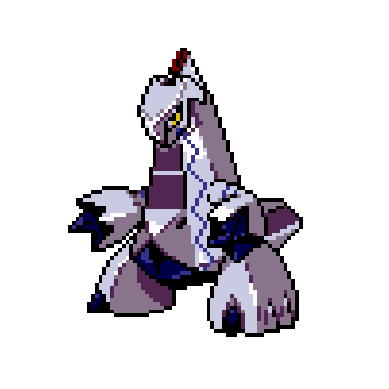

In [ ]:
img, _ = next(iter(dataloader))
print(torch.unique(img))
plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

Epoch 100/1500: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s, loss=0.00475, iters=400]


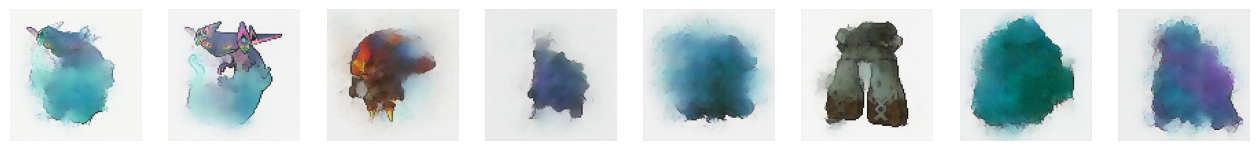

Epoch 200/1500: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, loss=0.00624, iters=800]


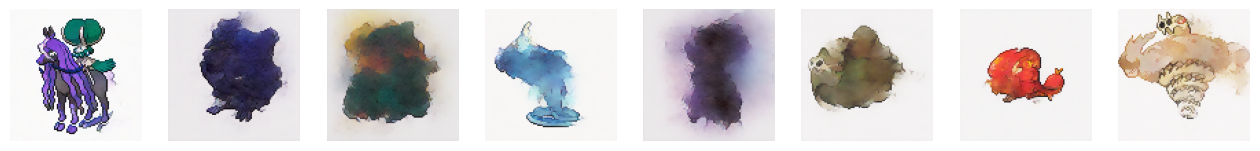

Epoch 300/1500: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, loss=0.00315, iters=1200]


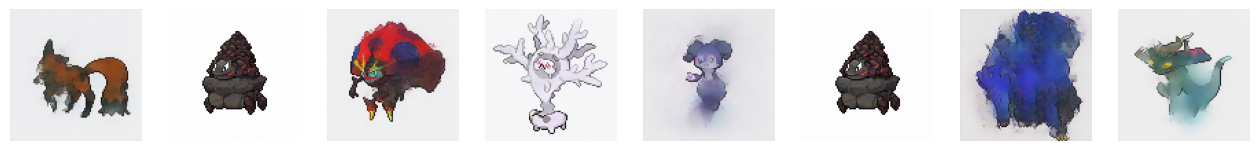

Epoch 400/1500: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, loss=0.00258, iters=1600]


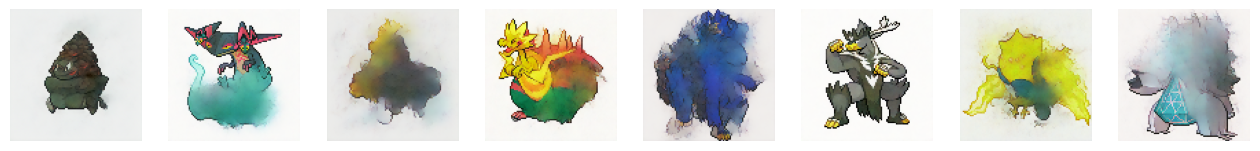

Epoch 500/1500: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s, loss=0.00334, iters=2000]


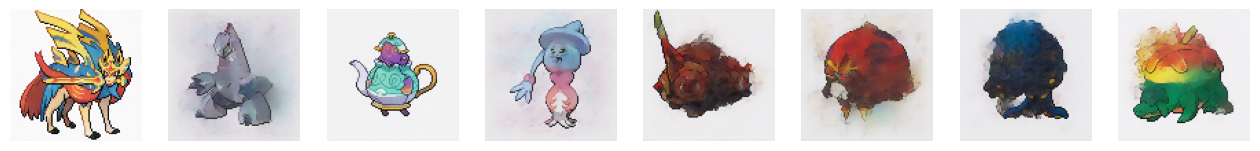

Epoch 600/1500: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, loss=0.00903, iters=2400]


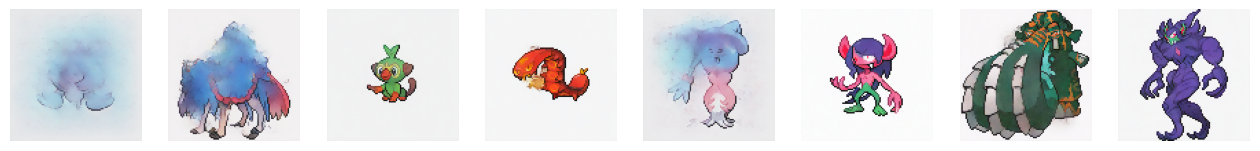

Epoch 700/1500: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, loss=0.00762, iters=2800]


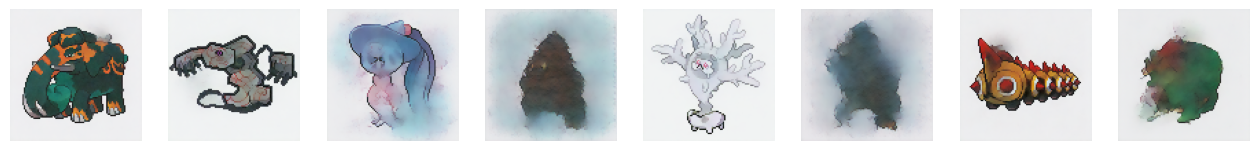

Epoch 800/1500: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, loss=0.00192, iters=3200]


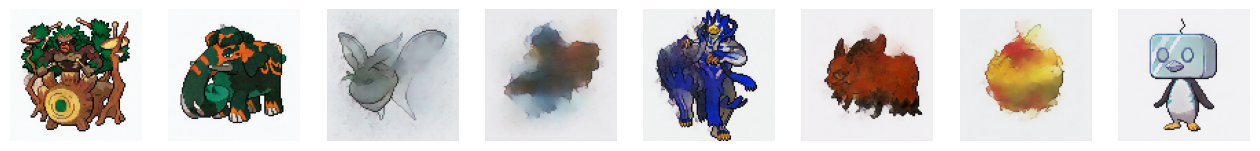

Epoch 900/1500: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, loss=0.00238, iters=3600]


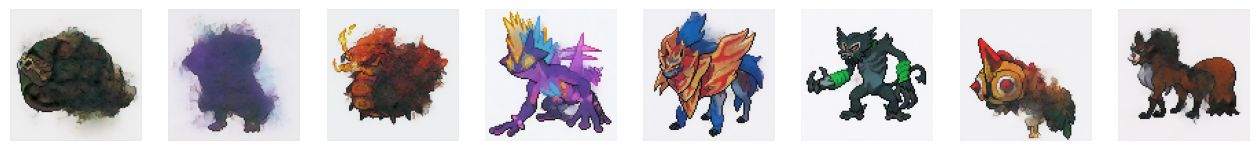

Epoch 1000/1500: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, loss=0.00144, iters=4000]


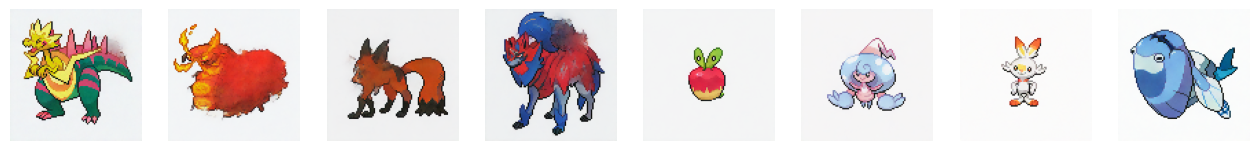

Epoch 1100/1500: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s, loss=0.00796, iters=4400]


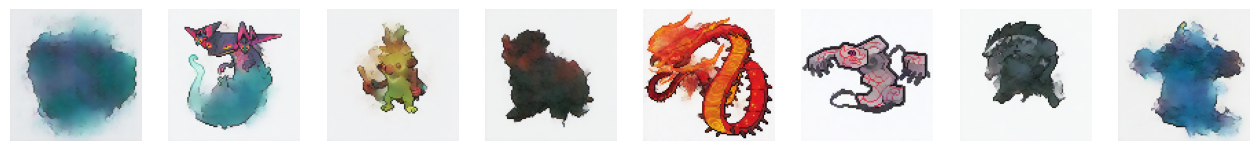

Epoch 1200/1500: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, loss=0.00149, iters=4800]


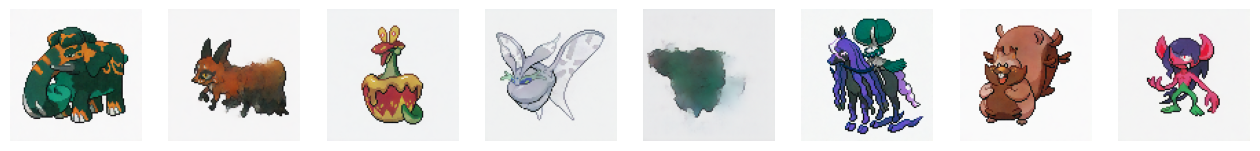

Epoch 1300/1500: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, loss=0.00195, iters=5200]


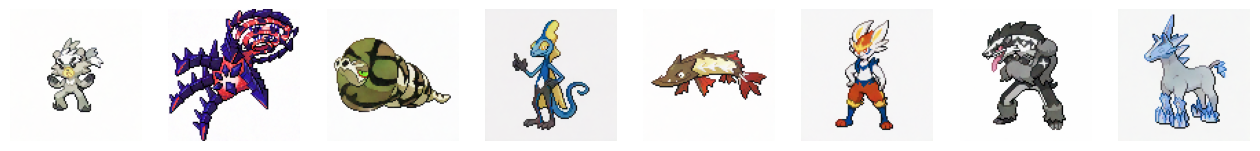

Epoch 1400/1500: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, loss=0.00151, iters=5600]


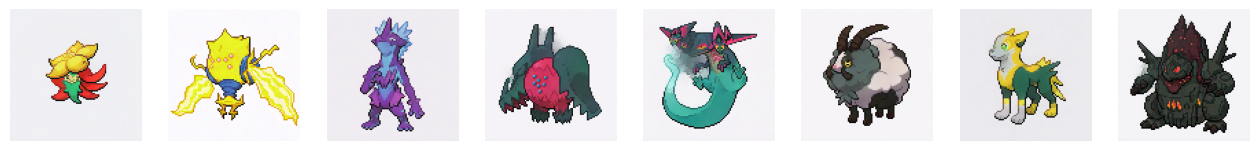

Epoch 1500/1500: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s, loss=0.00292, iters=6000]


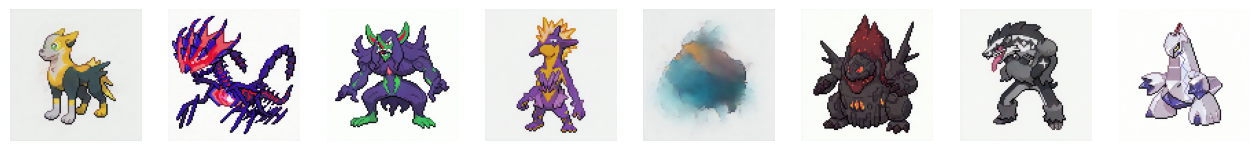

In [ ]:
num_epochs = 1500
iters = 0
for epoch in range(num_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for imgs, cond in pbar:
        imgs = imgs.to(device)
        cond = cond.to(device)

        loss = diffusion.training_step(imgs, cond)

        optimizer.zero_grad()
        loss.backward()

        # 🔹 Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # 🔹 EMA update
        update_ema(model, ema_model, ema_decay)

        iters += 1
        pbar.set_postfix({"loss": loss.item(), "iters": iters})

    if (epoch + 1) % 100 == 0:
        ema_model.eval()
        with torch.no_grad():
            _, cond_batch = next(iter(dataloader))
            cond_batch = cond_batch[:8].to(device)

            samples = diffusion.sample(cond=cond_batch, batch_size=8)
            samples = (samples * 0.5 + 0.5).clamp(0, 1)
        ema_model.train()

        fig, axes = plt.subplots(1, 8, figsize=(16, 2))
        for i in range(8):
            img = samples[i].permute(1, 2, 0).cpu().numpy()
            axes[i].imshow(img)
            axes[i].axis("off")
        plt.show()


In [ ]:
# 1. legendary, 2. mega_evolution, 3. alolan_form, 4. galarian_form, 5. gigantamax, 6. Bug, 7. Dark, 8. Dragon, 9. Electric, 10. Fairy, 11. Fighting, 12. Fire, 13. Flying, 14. Ghost, 15. Grass, 16. Ground, 17. Ice, 18. Normal, 19. Poison, 20. Psychic,
# 21. Rock, 22. Steel, 23. Water, 24. shape_Armor, 25. shape_Arms, 26. shape_Ball, 27. shape_Blob, 28. shape_Bug-Wings, 29. shape_Fish, 30. shape_Heads, 31. shape_Humanoid, 32. shape_Legs, 33. shape_Quadruped, 34. shape_Squiggle, 35. shape_Tentacles, 36. shape_Upright, 37. shape_Wings, 38. color_Black, 39. color_Blue, 40. color_Brown,
# 41. color_Gray, 42. color_Green, 43. color_Pink, 44. color_Purple, 45. color_Red, 46. color_White, 47. color_Yellow

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

feature_names = ["legendary", "mega_evolution", "alolan_form", "galarian_form", "gigantamax",
                 "Bug", "Dark", "Dragon", "Electric", "Fairy",
                 "Fighting", "Fire", "Flying", "Ghost", "Grass",
                 "Ground", "Ice", "Normal", "Poison", "Psychic",
                 "Rock", "Steel", "Water", "shape_Armor", "shape_Arms",
                 "shape_Ball", "shape_Blob", "shape_Bug-Wings", "shape_Fish", "shape_Heads",
                 "shape_Humanoid", "shape_Legs", "shape_Quadruped", "shape_Squiggle", "shape_Tentacles",
                 "shape_Upright", "shape_Wings", "color_Black", "color_Blue", "color_Brown",
                 "color_Gray", "color_Green", "color_Pink", "color_Purple", "color_Red",
                 "color_White", "color_Yellow"]
cond_dim = len(feature_names)
batch_size = 4

cond_batch = torch.zeros(batch_size, cond_dim)

cond_batch[0, feature_names.index("Fire")] = 1.0
cond_batch[0, feature_names.index("Ice")] = 1.0

cond_batch[1, feature_names.index("color_Black")] = 1.0
cond_batch[1, feature_names.index("color_White")] = 1.0

cond_batch[2, feature_names.index("Fairy")] = 1.0
cond_batch[2, feature_names.index("shape_Ball")] = 1.0
cond_batch[2, feature_names.index("shape_Tentacles")] = 1.0

cond_batch[2, feature_names.index("Flying")] = 1.0
cond_batch[2, feature_names.index("Grass")] = 1.0
cond_batch[2, feature_names.index("color_Red")] = 1.0
cond_batch[2, feature_names.index("Water")] = 1.0

cond_batch = cond_batch.to(device)

In [ ]:
with torch.no_grad():
    samples = diffusion.sample(cond=cond_batch, batch_size=batch_size)
    samples = (samples * 0.5 + 0.5).clamp(0, 1)

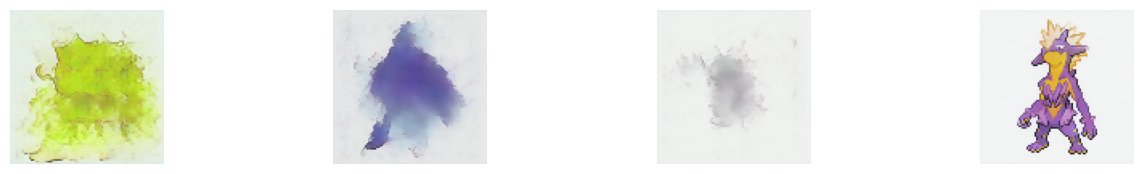

In [ ]:
fig, axes = plt.subplots(1, batch_size, figsize=(16, 2))
for i in range(batch_size):
    axes[i].imshow(samples[i].permute(1, 2, 0).cpu().numpy())
    axes[i].axis("off")
plt.show()

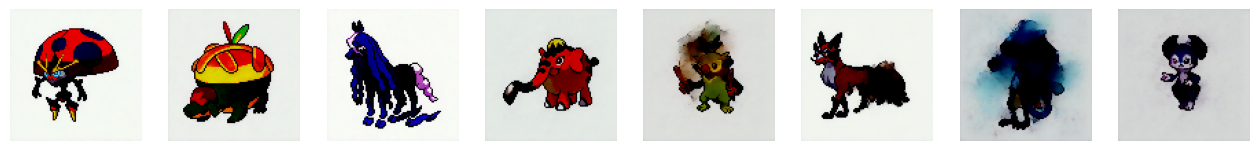

In [ ]:
"""
with torch.no_grad():
    _, cond_batch = next(iter(dataloader))
    cond_batch = cond_batch[:20].to(device)

    samples = diffusion.sample(cond=cond_batch, batch_size=20)

    fig, axes = plt.subplots(1, 8, figsize=(16, 2))
    for i in range(8):
        axes[i].imshow(samples[i].permute(1, 2, 0).cpu().numpy())
        axes[i].axis("off")
    plt.show()
"""

In [ ]:
torch.save(model.state_dict(), "unet_pokemon_concat4.pth")